## First you have to run the .R script and create the correpsonging files

In [ ]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os

 ## We have to manually save count matrix, tissue position list, image and scale factors from the R environment and load the files properly in an AnnData
 
 # Inside the sample folder, we must have the count matrix (path must be given to sc.read()) and the spatial folder with 3 files: Image, tissue_position_list and scale_factor

... storing 'in_tissue_y' as categorical
... storing 'array_row_y' as categorical
... storing 'array_col_y' as categorical


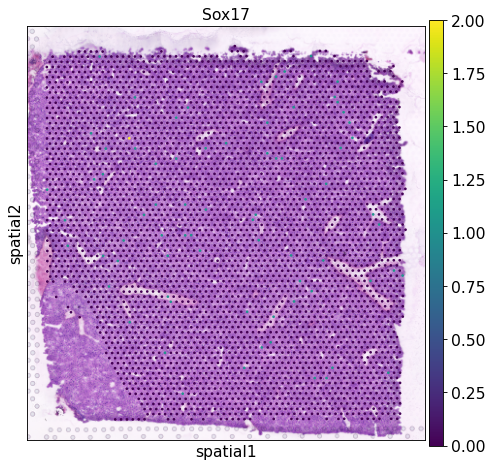

In [ ]:
adata = sc.read('<set_path>/<sample_name>/filtered_featured_bc_matrix.h5ad') 
adata

positions = pd.read_csv('<set_path>/<sample_name>/spatial/tissue_position_list.csv'', header=None)
positions.columns = [
    'barcode',
    'in_tissue',
    'array_row',
    'array_col',
    'pxl_col_in_fullres',
    'pxl_row_in_fullres',
]

positions = positions.drop(0)
adata.obs['barcode'] = adata.obs.index
adata.obs = adata.obs.merge(positions, how = 'left', on = 'barcode')
adata.obs.index = positions['barcode']
positions.index.name = None

adata.obsm['spatial'] = adata.obs[
    ['pxl_row_in_fullres', 'pxl_col_in_fullres']
].to_numpy(dtype = int)
adata.obs.drop(
    columns=['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres'],
    inplace=True,
)
adata.obsm
spatial_key = "spatial"
library_id = "tissue42"
adata.uns[spatial_key] = {library_id: {}}
adata.uns[spatial_key][library_id]["images"] = {}
adata.uns[spatial_key][library_id]["images"] = {"lowres": plt.imread("<set_path>/<sample_name>/spatial/lowres_tissue_img.png")[:,:,:]}
import json 
with open('<set_path>/<sample_name>/spatial/scalefactors_json.json') as json_file:
    scale_factor = json.load(json_file)
scale_factor['tissue_lowres_scalef'] = scale_factor.pop('lowres')
scale_factor['spot_diameter_fullres'] = scale_factor.pop('spot')
scale_factor['tissue_hires_scalef'] = scale_factor.pop('hires')
scale_factor['fiducial_diameter_fullres'] = scale_factor.pop('fiducial')
for keys in scale_factor:
    scale_factor[keys] = float(scale_factor[keys][0])
adata.uns[spatial_key][library_id]["scalefactors"] = scale_factor
sc.pl.spatial(adata,color = adata.var.index[0], size = 30)

## Checking the image from R has the correct orientation

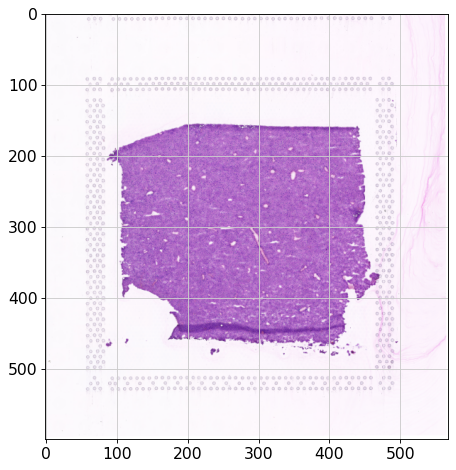

In [ ]:
import imageio
im = imageio.imread("./<sample_name>/spatial/lowres_tissue_img.png")
from scipy import ndimage
im = ndimage.rotate(im, 90,reshape=True)
im = np.flipud(im)
import matplotlib.pyplot as plt
plt.imshow(im)
imageio.imsave("./<sample_name>/spatial/lowres_tissue_img.png", im) 